# 1. Data Preprocess

In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import io
import numpy as np
import tensorflow as tf
import re
import os
from sklearn.model_selection import train_test_split
import pickle
from pyvi import ViTokenizer

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
BOS = '<start>'
EOS = '<end>'
UTF_8 = 'UTF-8'
SOURCE = 'data/train.en.txt'
DESTINATION = 'data/train.vi.txt'

In [38]:
def preprocess_sentence(w, language):
    w = w.lower().strip()
    w = re.sub(r"([?.!,¿@#$%&*~:;])", r"", w)
    w = re.sub('apos', '\'', w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.replace('-', '')
    w = w.strip()

    w = " ".join(w.split())

    # Vietnamese Word Separation
    if language == 'vi':
      w = ViTokenizer.tokenize(w)

    # Add start and end token 
    w = '{} {} {}'.format(BOS, w, EOS)
    return w

In [39]:
preprocess_sentence("Rachel Pike : The science behind a climate headline", 'en')

'<start> rachel pike the science behind a climate headline <end>'

In [40]:
inp_lines = io.open(SOURCE, encoding=UTF_8).read().strip().split('\n')
targ_lines = io.open(DESTINATION, encoding=UTF_8).read().strip().split('\n')

In [41]:
len(inp_lines)

133317

In [42]:
len(targ_lines)

133317

In [44]:
inp_lines = [preprocess_sentence(inp,'en') for inp in inp_lines]
targ_lines = [preprocess_sentence(targ,'vi') for targ in targ_lines]

In [45]:
for i in range(5):
    print(f'Source: {inp_lines[i]}')
    print(f'Destination: {targ_lines[i]}')
    print()

Source: <start> rachel pike the science behind a climate headline <end>
Destination: <start> khoa_học đằng sau một tiêu_đề về khí_hậu <end>

Source: <start> in 4 minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule <end>
Destination: <start> trong 4 phút chuyên_gia hoá_học khí_quyển rachel pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng sau những tiêu_đề táo_bạo về biến_đổi khí_hậu cùng với đoàn nghiên_cứu của mình hàng ngàn người đã cống_hiến cho dự_án này một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt <end>

Source: <start> i 'd like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
Destination: <start> tôi muốn cho các bạn biết về sự to_lớn của những nỗ

In [26]:
%mkdir vocab

/bin/bash: /home/quyet-invisible/anaconda3/envs/nlp_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [46]:
# Tokenizer --> Word2Vec
inp_tokenizers = tf.keras.preprocessing.text.Tokenizer()
inp_tokenizers.fit_on_texts(inp_lines)

targ_tokenizers = tf.keras.preprocessing.text.Tokenizer()
targ_tokenizers.fit_on_texts(targ_lines)

In [47]:
EN_TOKENIZER_PATH = 'vocab/en_tokenizer.pickle'
VI_TOKENIZER_PATH = 'vocab/vi_tokenizer.pickle'

if not os.path.exists(EN_TOKENIZER_PATH):
    with open(EN_TOKENIZER_PATH, 'wb') as handle:
      pickle.dump(inp_tokenizers, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(VI_TOKENIZER_PATH, 'wb') as handle:
      pickle.dump(targ_tokenizers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [113]:
MAX_TOKENS = 64
inp_tensor = inp_tokenizers.texts_to_sequences(inp_lines)
inp_tensor = tf.keras.preprocessing.sequence.pad_sequences(inp_tensor, padding='post', maxlen=MAX_TOKENS)
targ_tensor = targ_tokenizers.texts_to_sequences(targ_lines)
targ_tensor = tf.keras.preprocessing.sequence.pad_sequences(targ_tensor, padding='post', maxlen=MAX_TOKENS)

In [114]:
inp_tensor_train, inp_tensor_val, targ_tensor_train, targ_tensor_val = train_test_split(inp_tensor, targ_tensor, test_size=0.2)
train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(inp_tensor_train, dtype=tf.int64), tf.convert_to_tensor(targ_tensor_train, dtype=tf.int64)))
train_dataset = train_dataset.shuffle(20000).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(inp_tensor_val, dtype=tf.int64), tf.convert_to_tensor(targ_tensor_val, dtype=tf.int64)))
val_dataset = val_dataset.shuffle(20000).batch(64)

In [115]:
inp_tensor_train.shape

(106653, 64)

In [116]:
inp_tensor_val.shape

(26664, 64)

In [117]:
for (batch, (inp, targ)) in enumerate(train_dataset):
    print(inp)
    print(targ)
    break

tf.Tensor(
[[  1  19  79 ...   0   0   0]
 [  1   4  13 ...   0   0   0]
 [  1   9  79 ...   0   0   0]
 ...
 [  1   2   0 ...   0   0   0]
 [  1 298  12 ...   0   0   0]
 [  1   4   9 ...   0   0   0]], shape=(64, 64), dtype=int64)
tf.Tensor(
[[   1    8 1892 ...    0    0    0]
 [   1    3    8 ...    0    0    0]
 [   1    4   20 ...    0    0    0]
 ...
 [   1  835  269 ...    0    0    0]
 [   1  160  297 ...    0    0    0]
 [   1    3    4 ...    0    0    0]], shape=(64, 64), dtype=int64)


# 2. Visualize data

In [118]:
from collections import Counter

In [119]:
counter = Counter(inp_tokenizers.word_counts)

In [120]:
counter.most_common(22)

[('start', 134600),
 ('end', 134452),
 ('the', 109723),
 ('and', 79674),
 ('to', 65979),
 ('of', 60510),
 ('a', 55386),
 ('that', 49320),
 ('i', 43652),
 ('in', 41318),
 ('it', 39067),
 ('you', 37438),
 ('we', 35089),
 ('is', 33820),
 ("'s", 29554),
 ('this', 25755),
 ('so', 19459),
 ('quot', 18923),
 ('they', 17535),
 ('for', 16153),
 ('was', 16017),
 ('are', 14669)]

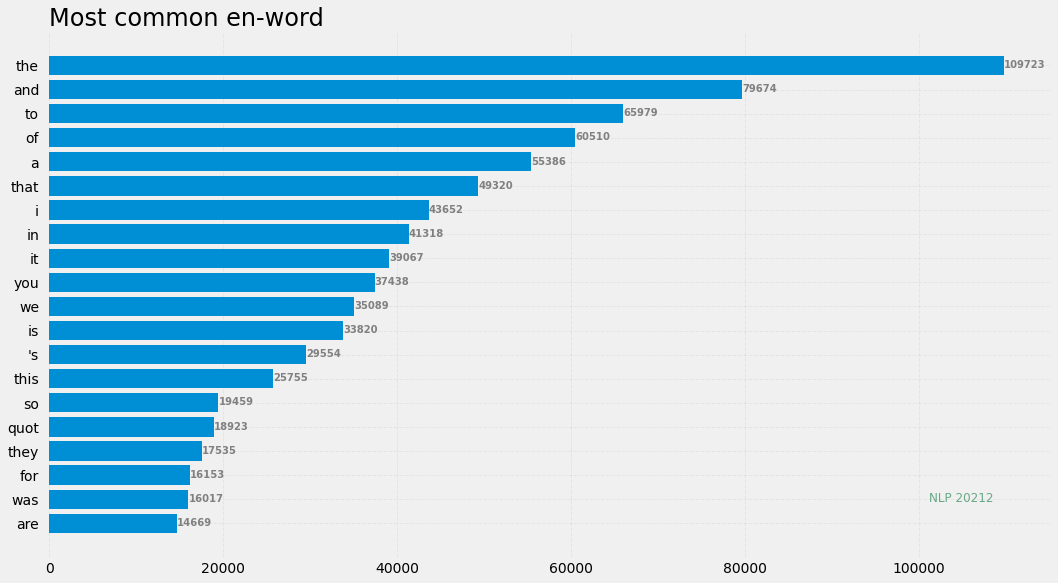

In [121]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize =(16, 9))
words = [k for k,v in counter.most_common(22)[2:]]
count = [v for k,v in counter.most_common(22)[2:]]

ax.barh(words, count)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
ax.invert_yaxis()
 
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
ax.set_title('Most common en-word',
             loc ='left', fontdict={'fontsize': 24})
 
fig.text(0.9, 0.15, 'NLP 20212', fontsize = 12,
         color ='seagreen', ha ='right', va ='bottom',
         alpha = 0.7)
 
plt.show()

In [122]:
vi_counter = Counter(targ_tokenizers.word_counts)

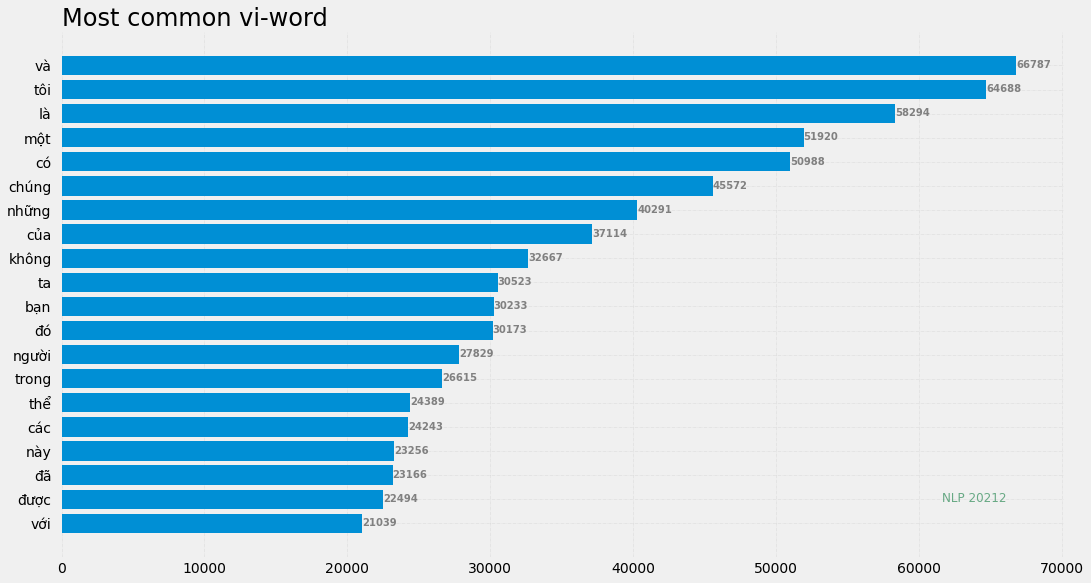

In [123]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize =(16, 9))
words = [k for k,v in vi_counter.most_common(22)[2:]]
count = [v for k,v in vi_counter.most_common(22)[2:]]

ax.barh(words, count)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
ax.invert_yaxis()
 
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
ax.set_title('Most common vi-word',
             loc ='left', fontdict={'fontsize': 24})
 
fig.text(0.9, 0.15, 'NLP 20212', fontsize = 12,
         color ='seagreen', ha ='right', va ='bottom',
         alpha = 0.7)
 
plt.show()

# 3. Model Transformer

## 3.1. Positional Encoding

In [124]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [125]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


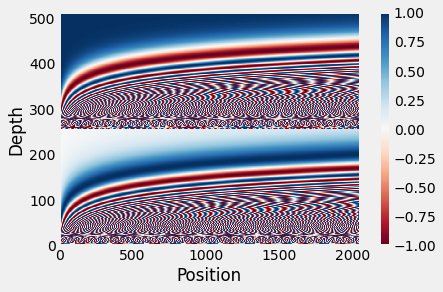

In [126]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## 3.2. Masking

In [127]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [128]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x).numpy()

array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)

In [129]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [130]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp.numpy()

array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)

## 3.3. Scaled dot product attention

In [131]:
def scaled_dot_product_attention(q, k, v, mask):
  """
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## 3.4. Multi-head attention

In [132]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

## 3.5. Point-wise feed forward network

In [133]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## 3.6. Encoder

In [134]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [135]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

## 3.7. Decoder

In [136]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [137]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## 3.8. Transformer

In [138]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [139]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# 4. Train

## 4.1. Hyperparameters

In [140]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## 4.2. Optimizer

In [141]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [142]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

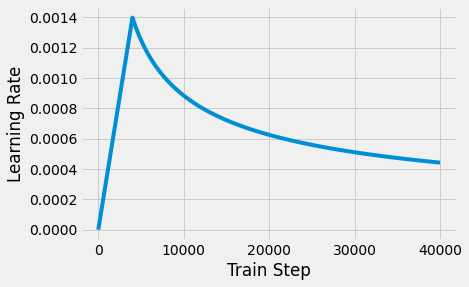

In [143]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## 4.3. Loss - Metric

In [144]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [145]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [146]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

In [147]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(inp_tokenizers.word_counts) + 1,
    target_vocab_size=len(targ_tokenizers.word_counts) + 1,
    rate=dropout_rate)

In [148]:
checkpoint_path = 'checkpoints/'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [149]:
EPOCHS = 20

In [150]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [151]:
import pandas as pd

evaluate = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print('########## Start training: .............')

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  print(f'=============================================== TRAIN EPOCH {epoch + 1} ===============================================')

  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 64 == 0:
      print(f'Batch #{int(batch/64)}: train_loss:{train_loss.result():.4f}, train_accuracy:{train_accuracy.result():.4f}')
      
  val_loss = 0
  val_acc = 0
  for (val_b, (val_inp, val_tar)) in enumerate(val_dataset):
    val_tar_inp = val_tar[:, :-1]
    val_tar_real = val_tar[:, 1:]

    with tf.GradientTape() as tape:
        val_predictions, tmp = transformer([val_inp, val_tar_inp],
                                 training = False)
        val_loss += loss_function(val_tar_real, val_predictions)
        val_acc += accuracy_function(val_tar_real, val_predictions)
   
  val_loss = val_loss/len(val_dataset)
  val_acc = val_acc/len(val_dataset)
        
  print(f'=============================================== METRIC EPOCH {epoch + 1} ==============================================')
  print(f'train_loss:{train_loss.result():.4f}, train_accuracy:{train_accuracy.result():.4f}, val_loss:{val_loss:.4f}, val_accuracy:{val_acc:.4f}')
  evaluate['train_loss'].append(round(train_loss.result().numpy(), 4))
  evaluate['train_acc'].append(round(train_accuracy.result().numpy(), 4))
  evaluate['val_loss'].append(round(val_loss.numpy(), 4))
  evaluate['val_acc'].append(round(val_acc.numpy(), 4))

  print(f'Time taken: {time.time() - start:.2f} secs\n')
  if epoch + 1 > 1:
        if val_acc > max(evaluate['val_acc']):
            ckpt_save_path = ckpt_manager.save()
            print(f'############### Saving best checkpoint at epoch {epoch+1} at {ckpt_save_path} ...')

df = pd.DataFrame(evaluate)
df.to_csv('metric.csv', encoding='utf-8', index=False)

########## Start training: .............
=============================================== TRAIN EPOCH 1 ===============================================
Batch #0: train_loss:9.9344, train_accuracy:0.0035
Batch #1: train_loss:9.8733, train_accuracy:0.0116
Batch #2: train_loss:9.7341, train_accuracy:0.0276
Batch #3: train_loss:9.5109, train_accuracy:0.0327
Batch #4: train_loss:9.2160, train_accuracy:0.0353
Batch #5: train_loss:8.8823, train_accuracy:0.0369
Batch #6: train_loss:8.5529, train_accuracy:0.0381
Batch #7: train_loss:8.2656, train_accuracy:0.0388
Batch #8: train_loss:8.0352, train_accuracy:0.0394
Batch #9: train_loss:7.8487, train_accuracy:0.0406
Batch #10: train_loss:7.6902, train_accuracy:0.0439
Batch #11: train_loss:7.5508, train_accuracy:0.0481
Batch #12: train_loss:7.4206, train_accuracy:0.0531
Batch #13: train_loss:7.2997, train_accuracy:0.0581
Batch #14: train_loss:7.1861, train_accuracy:0.0633
Batch #15: train_loss:7.0798, train_accuracy:0.0686
Batch #16: train_loss:6.980

# 5. Evaluate metric

In [152]:
metric = pd.read_csv('metric.csv')

In [159]:
metric.head()

,train_loss,train_acc,val_loss,val_acc
0,6.2530,0.1214,4.7503,0.2314
1,4.4005,0.2637,3.8775,0.3303
2,3.6687,0.3553,3.2791,0.4147
3,3.1329,0.4273,2.9332,0.4650
4,2.8154,0.4703,2.7918,0.4868


Text(0, 0.5, 'Loss')

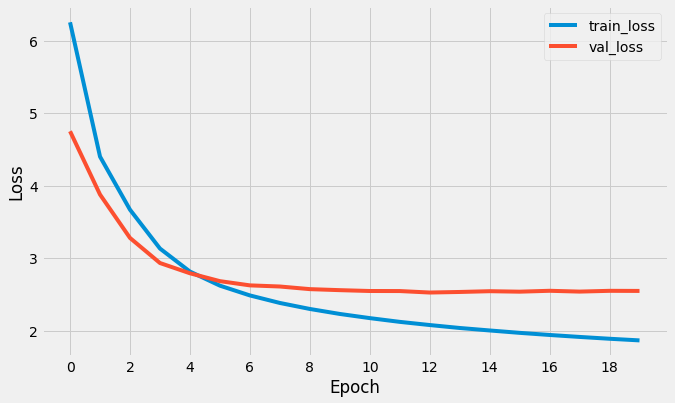

In [158]:
lines = metric[['train_loss', 'val_loss']].plot.line(xticks=range(0,20,2),figsize=(10,6))
lines.set_xlabel("Epoch")
lines.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

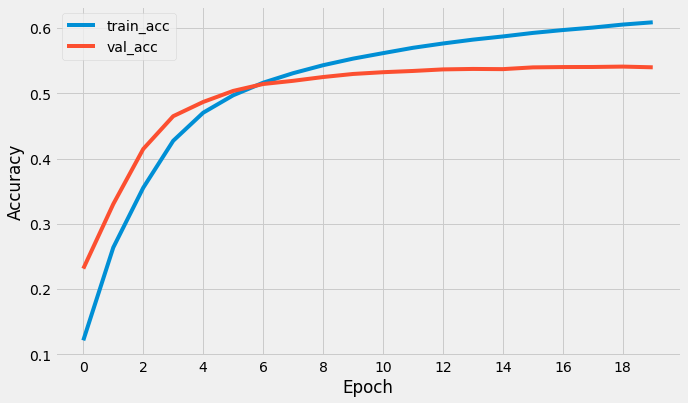

In [160]:
lines = metric[['train_acc', 'val_acc']].plot.line(xticks=range(0,20,2),figsize=(10,6))
lines.set_xlabel("Epoch")
lines.set_ylabel("Accuracy")

# 6. Run inference

In [206]:
class Translator(tf.Module):
  def __init__(self, en_tokenizers, vi_tokenizers, transformer):
    self.en_tokenizers = en_tokenizers
    self.vi_tokenizers = vi_tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    sentence = preprocess_sentence(sentence, 'en')
    encoder_input = tf.constant(self.en_tokenizers.texts_to_sequences([sentence]), dtype=tf.int64)

    # print(encoder_input)

    # As the output language is english, initialize the output with the
    # english start token.
    start = tf.constant([1], dtype=tf.int64)
    end = tf.constant([2], dtype=tf.int64)

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = self.vi_tokenizers.sequences_to_texts(output.numpy())  # shape: ()

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, attention_weights

In [207]:
translator = Translator(inp_tokenizers, targ_tokenizers, transformer)

In [208]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens[0].replace("start ", "").replace("end","").capitalize()}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [209]:
sentence = 'When I was little , I thought my country was the best on the planet , and I grew up singing a song called &quot; Nothing To Envy . &quot;'
ground_truth = 'Khi tôi còn nhỏ , Tôi nghĩ rằng BắcTriều Tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài &quot; Chúng ta chẳng có gì phải ghen tị . &quot;'

translated_text, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : When I was little , I thought my country was the best on the planet , and I grew up singing a song called &quot; Nothing To Envy . &quot;
Prediction     : Khi tôi còn nhỏ tôi nghĩ đất nước tôi là người giỏi nhất trên hành tinh và tôi lớn lên hát một bài hát gọi là quot không có gì ghen tị quot 
Ground truth   : Khi tôi còn nhỏ , Tôi nghĩ rằng BắcTriều Tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài &quot; Chúng ta chẳng có gì phải ghen tị . &quot;


In [204]:
inp_test = io.open('data/tst2013.en.txt', encoding=UTF_8).read().strip().split('\n')
targ_test = io.open('data/tst2013.vi.txt', encoding=UTF_8).read().strip().split('\n')

In [211]:
for (idx, (sentence, ground_truth)) in enumerate(zip(inp_test[:10], targ_test[:10])):
    print(f'============================================================================= SAMPLE {idx+1} ============================================================================= ')
    translated_text, attention_weights = translator(sentence)
    print_translation(sentence, translated_text, ground_truth)

============================================================================= SAMPLE 1 ============================================================================= 
Input:         : When I was little , I thought my country was the best on the planet , and I grew up singing a song called &quot; Nothing To Envy . &quot;
Prediction     : Khi tôi còn nhỏ tôi nghĩ đất nước tôi là người giỏi nhất trên hành tinh và tôi lớn lên hát một bài hát gọi là quot không có gì ghen tị quot 
Ground truth   : Khi tôi còn nhỏ , Tôi nghĩ rằng BắcTriều Tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài &quot; Chúng ta chẳng có gì phải ghen tị . &quot;
============================================================================= SAMPLE 2 ============================================================================= 
Input:         : And I was very proud .
Prediction     : Và tôi rất tự hào 
Ground truth   : Tôi đã rất tự hào về đất nước tôi .
========================================================